<a href="https://colab.research.google.com/github/juanserrano90/raaa67_bayes/blob/main/notebooks/1_intro_pymc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

# Introducción a PyMC

## Datos

Vamos a construir y ajustar un modelo lineal para aprender los conceptos básicos de PyMC.

In [2]:
# Generemos un dataset X, Y
seed = 42
np.random.seed(seed)

alpha, beta, sigma = 1, 1, 1
size = 100

X = np.random.randn(size)
Y = alpha + beta * X + np.random.normal(size=size) * sigma

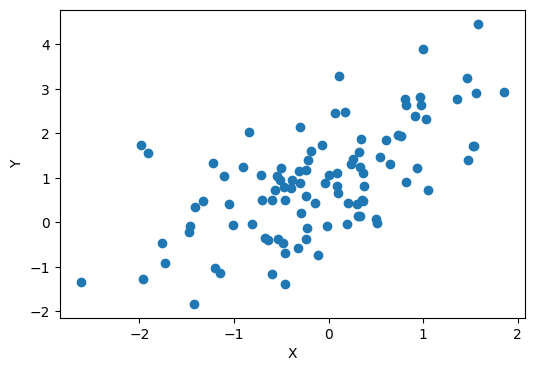

In [3]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(X, Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

## Supuestos del modelo

**Modelo Lineal: formulación bayesiana**

Podemos pensar un modelo probabilístico como una serie de supuestos sobre el proceso de generación de los datos que vamos a ajustar.

Si nuestros datos son vectores $(X, Y)$, definimos el modelo como:

$$
\mu = \alpha + \beta X
$$
$$
Y \sim \mathcal{N}(\mu, \sigma^2)
$$
donde $\alpha$, $\beta$ son los coeficientes del modelo lineal y $\sigma$ la desviación estándar de los errores, con **priors**:
$$
\alpha \sim \mathcal{N}(0, 100), \quad
\beta \sim \mathcal{N}(0, 100), \quad
\sigma \sim \text{HalfNormal}(5)
$$


En la documentación podemos ver todas las [distribuciones](https://www.pymc.io/projects/docs/en/stable/api/distributions.html) que contiene PyMC, que usaremos para definir los priors y likelihoods.

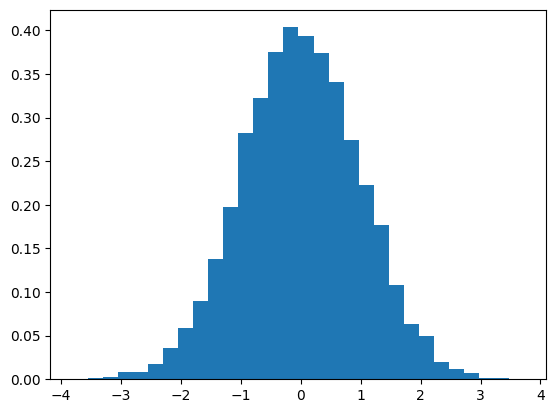

In [4]:
# Ejemplo, distribución Normal.
y = pm.Normal.dist(0,1)
samples = pm.draw(y, draws=10000)
plt.hist(samples, bins=30, density=True);

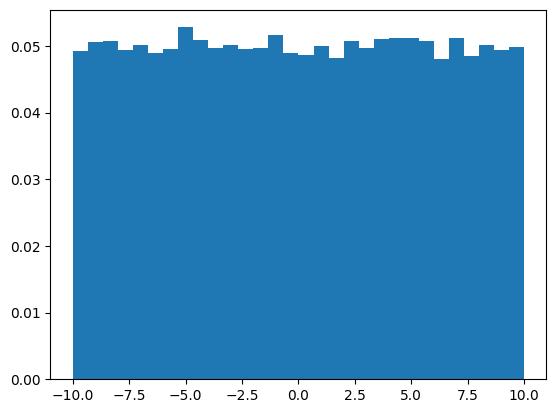

In [5]:
# Ejemplo, distribución Uniforme.
y = pm.Uniform.dist(-10,10)
samples = pm.draw(y, draws=50000)
plt.hist(samples, bins=30, density=True);

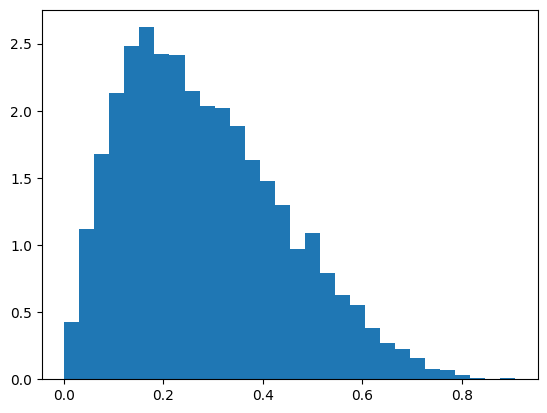

In [6]:
# Ejemplo, distribución Beta.
y = pm.Beta.dist(alpha=2, beta=5)
samples = pm.draw(y, draws=10000)
plt.hist(samples, bins=30, density=True);

## Instanciando un modelo

Para crear un modelo debemos instanciar un objeto `pm.Model()` dentro de un *gestor de contexto*: `with ..`, el objeto funciona como un contenedor para las variables de nuestro modelo.



In [7]:
with pm.Model() as linear_model:

  # Priors
  alpha = pm.Normal('alpha', mu=0, sigma=100)
  beta = pm.Normal('beta', mu=0, sigma=100)
  sigma = pm.HalfNormal('sigma', sigma=5)

Al definir el modelo probabilístico tenemos dos tipos de variables:

i) Las variables **estocásticas**, se llaman así porque son basicamente generadores de números aleatorios con cierta distribución. Notar que el primer argumento de una variable es el nombre, es el alias interno que tendrá cada variable.

En el backend, las variables son objetos `TensorVariable` de `pytensor`.

In [8]:
with linear_model:

  # Computemos el valor esperado mu
  mu = alpha + beta * X

  # Si queremos que se guarde el valor de mu, debemos darle un nombre
  pm.Deterministic('mu', mu)

ii) Las variables determinísticas, como `mu`, se llaman así porque si bien su valor será aleatorio (depende de variables aleatorias), es una función determinística de variables aleatorias. Ante iguales valores de entrada, el resultado será un mismo valor. Notar que podemos operar matemáticamente como queramos con las variables aleatorias del modelo, creando nuevas variables. Están disponibles funciones como `sum`, `sin` y `exp`, y también las funciones de `pytensor`.

Por último, agreguemos las observaciones.

In [9]:
with linear_model:

  # Esto agrega la likelihood al modelo
  y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y)

Acá, y_obs es un tipo especial de variable estocástica porque es *observada*. Es la variable a la que estamos condicionando el modelo. El parámetro `observed` indica que los valores de esta variable están fijos, y no serán modificados. Notar además que los parámetros de esta variable Normal son a su vez variables estocásticas, esto genera una relación *parent-child* entre `y_obs` con `mu` y `sigma`.

Con esto nuestro modelo ya está listo para la inferencia!

Pero antes inspeccionemos un poco lo que hicimos.

## Inspeccionando el modelo

In [10]:
linear_model

In [11]:
# Algunos atributos
print(linear_model.free_RVs)
print(linear_model.observed_RVs)
print(linear_model.deterministics)

[alpha, beta, sigma]
[y_obs]
[mu]


Es común usar representaciones de grafos en modelos bayesianos, la función `model_to_graphviz` ofrece una. Es útil para chequear la estructura de relaciones entre variables, las variables observadas, número de observaciones, variables estocásticas y determinísticas.

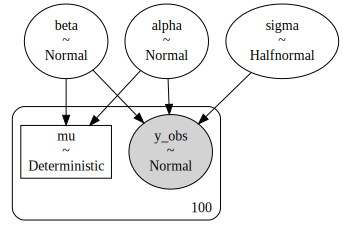

In [12]:
pm.model_to_graphviz(linear_model)

También podemos computar la *prior predictive distribution* con `pm.sample_prior_predictive`. Esto es, la predicción de los datos que hace nuestro modelo *antes* de observarlos (notar que es muy parecida a la ecuación de la marginal likelihood, pero acá es una distribución esperada de `y`, mientras que la marginal es un número).

$$
p(y \mid \theta) \;=\; \int p(y \mid \theta)~p(\theta)~d\theta
$$

Analizar la PP es útil para visualizar que tanto conocimiento previo estamos incorporando en nuestras hipótesis.


In [13]:
with linear_model:

  # Sampleamos 100 muestras
  prior_samples = pm.sample_prior_predictive(draws=100, return_inferencedata=True, random_seed=seed)

`az.InferenceData` es un formato de datos especializado para usuarios de MCMC en el contexto bayesiano.  Está basado en **xarray**, un paquete para manejar arreglos N-dimensionales de forma flexible.  

El propósito principal de un objeto `az.InferenceData` es almacenar y manipular de manera conveniente la información generada durante un flujo de trabajo bayesiano. Toda esta información se organiza en **grupos** dentro del objeto.


In [14]:
prior_samples

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [15]:
prior = prior_samples.prior
print(prior['alpha'].shape)
print(type(prior['alpha']))

(1, 100)
<class 'xarray.core.dataarray.DataArray'>


In [16]:
grid_x = xr.DataArray(np.linspace(X.min(), X.max(), 100), dims=["plot_dim"])
prior_y = prior['alpha'] + prior['beta'] * grid_x

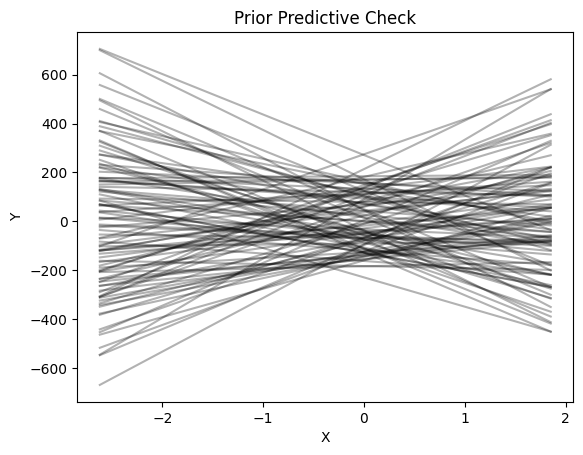

In [17]:
fig, ax = plt.subplots()

ax.set_title('Prior Predictive Check')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.plot(grid_x, prior_y.stack(sample=('chain', 'draw')), c="k", alpha=0.3);

In [18]:
with pm.Model() as linear_model:
  # Priors
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10)
  sigma = pm.HalfNormal('sigma', sigma=2)

  # Computemos el valor esperado mu
  mu = alpha + beta * X

  # Si queremos que se guarde el valor de mu, debemos darle un nombre
  pm.Deterministic('mu', mu)

  # Esto agrega la likelihood al modelo
  y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y)

  # Sampleamos 100 muestras
  prior_samples = pm.sample_prior_predictive(draws=100, return_inferencedata=True, random_seed=seed)

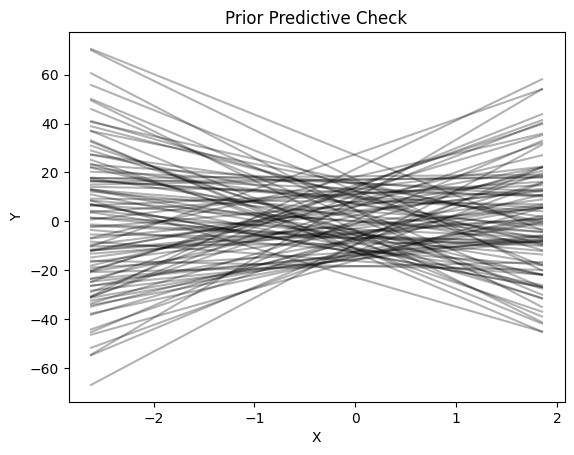

In [19]:
prior = prior_samples.prior
grid_x = xr.DataArray(np.linspace(X.min(), X.max(), 100), dims=["plot_dim"])
prior_y = prior['alpha'] + prior['beta'] * grid_x

fig, ax = plt.subplots()

ax.set_title('Prior Predictive Check')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.plot(grid_x, prior_y.stack(sample=('chain', 'draw')), c="k", alpha=0.3);

La estimación de parámetros Bayesiana es precisamente **toda la distribución** de probabilidades para los parámetros, que no es un número, sino una función que mapea cada valor del parámetro con su *plausiblidad*. Para una estimación puntual de la posterior, es común usar el *máximo a posteriori* (MAP), que se define como la moda de la distribución, es decir, el valor más probable.

PyMC ofrece un método para computar el *máximo local a posteriori* en la función `pm.find_MAP()`. Utiliza un método de optimización para aproximar el MAP. Es una práctica común utilizar esta estimación para iniciar las cadenas de markov ([aunque no recomendada](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.find_MAP.html)).

In [20]:
# Se debe ejecutar en el contexto de un modelo con variables observadas
with linear_model:
  map = pm.find_MAP()

Output()

In [21]:
print('MAP alpha:', map['alpha'])
print('MAP beta:', map['beta'])
print('MAP sigma:', map['sigma'])

MAP alpha: 1.0073282284758414
MAP beta: 0.8566390585416199
MAP sigma: 0.9389829840420385


## Inferencia con MCMC

Ok, el MAP da valores razonables, todo parece estar bien. Hora de apretar el botón de inferencia!

LLamaremos a la función [`pm.sample()`](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html). Por ahora, los parámetros que nos interesan son:

- `draws`: el número de muestras por cadena.
- `tune`: el número de iteraciones que se usarán para auto-tunear el step size y la cantidad de pasos.
- `chains`: la cantidad de cadenas, generalmente con 2 está bien, pero se recomiendan al menos 4 para obtener indicadores de convergencia robustos.
- `initvals` y `init` permiten especificar un punto de inicio de las cadenas y elegir entre distintos métodos de iniciación, respectivamente. Nosotros nos quedaremos con el iniciador por default de `NUTS`.

In [22]:
with linear_model:
  # Guardamos la traza un objeto InferenceData de arviz
  trace = pm.sample(
      draws=1000,
      tune=1000,
      chains=4,
      cores=4,
      random_seed=seed,
      return_inferencedata=True
      )

Output()

Eso fue rápido. Y no hay divergencias. Las divergencias indican que hubo un problema con el integrador numérico y por lo tanto esa muestra se descartó. Esto puede suceder por regiones de alta curvatura en la posterior, variables muy correlacionadas o problemas de parametrización/definición del modelo.

Cuando son muchas, son un buen indicador de que algo esta mal en la definición del modelo. Si son pocas, no es para preocuparse.

Soluciones posibles:
 - Reparametrizar
 - Aumentar `target_accept`, por ejemplo a 0.95. El default es 0.9.

### Traceplot

Lo siguiente que podemos hacer es inspeccionar visualmente las trazas, usemos la función `trace_plot` de arviz. Aquí podemos ver como se exploró el espacio de parámetros y un KDE para cada parámetro y cadena.

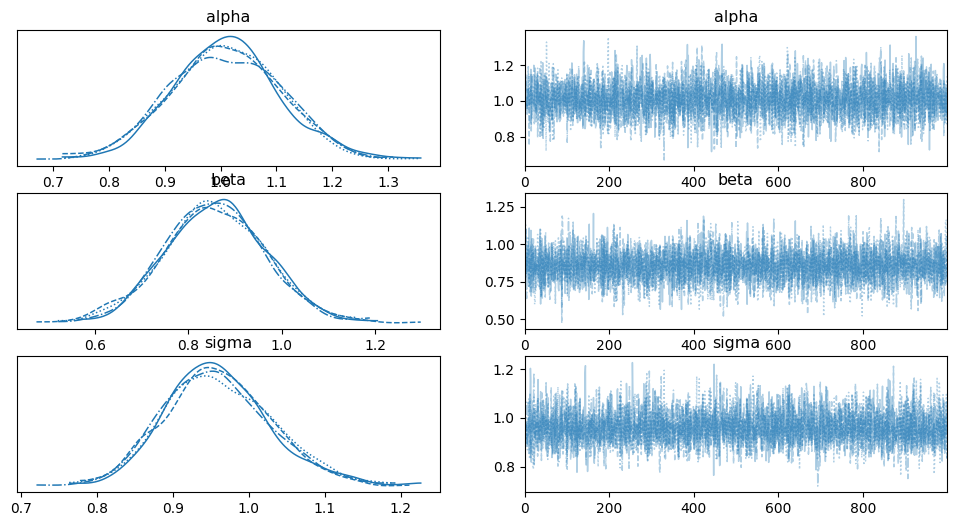

In [23]:
_ = az.plot_trace(trace, var_names=['alpha', 'beta', 'sigma'])

Las 4 cadenas se ven muy similares, buena señal.

### Diagnósticos

`az.summary()` nos calcula una serie de estadísticos del posterior y diagnósticos de convergencia.

In [24]:
summary = az.summary(trace,
                     hdi_prob=0.68,
                     stat_focus='median',
                     var_names = ['alpha', 'beta', 'sigma'])
summary

,median,mad,eti_16%,eti_84%,mcse_median,ess_median,ess_tail,r_hat
alpha,1.008,0.066,0.912,1.107,0.002,4689.687,3119.0,1.0
beta,0.856,0.071,0.752,0.963,0.002,5085.535,2958.0,1.0
sigma,0.955,0.047,0.892,1.029,0.001,5060.026,2820.0,1.0


- `ess_median`, `ess_tail` (Effective Sample Size):  
  Número efectivo de muestras independientes en la mediana de las variables.  
  Si el ESS es cercano a la cantidad total de muestras, indica una baja auto-correlación. Para parámetros complicados de samplear, >400 puede ser un criterio razonable.

- `r_hat`:  
  Estadístico de Gelman–Rubin.  
  Compara la varianza entre cadenas con la varianza dentro de cada cadena.  
  Valores cercanos a **1.0** indican convergencia; valores > 1.01 sugieren problemas.

- `mcse_median` (Monte Carlo Standard Error, median):  
  Estima la incertidumbre adicional debida a que solo tenemos un número finito de muestras. Un buen criterio es compararlo a la dispersión de la muestra.

In [25]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))
flat_samps

<xarray.Dataset> Size: 3MB
Dimensions:   (sample: 4000, mu_dim_0: 100)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * sample    (sample) object 32kB MultiIndex
  * chain     (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw      (sample) int64 32kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    alpha     (sample) float64 32kB 0.8705 0.7557 1.109 ... 0.9345 0.9635 1.059
    beta      (sample) float64 32kB 0.7907 0.8399 0.9279 ... 1.05 0.9432 0.9583
    mu        (mu_dim_0, sample) float64 3MB 1.263 1.173 1.569 ... 0.7423 0.8337
    sigma     (sample) float64 32kB 0.9951 0.9281 0.9613 ... 0.9737 0.8824
Attributes:
    created_at:                 2025-09-16T15:45:34.652068+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    sampling_time:              6.787476301193237
    tuning_steps:               1000

In [26]:
alpha_ = np.percentile(flat_samps['alpha'].values, [16,50,84], axis=-1)
beta_ = np.percentile(flat_samps['beta'].values, [16,50,84], axis=-1)
sigma_ = np.percentile(flat_samps['sigma'].values, [16,50,84], axis=-1)

print(f"alpha: {alpha_[1]:.2f} -{alpha_[1]-alpha_[0]:.2f} +{alpha_[2]-alpha_[1]:.2f}")
print(f"beta: {beta_[1]:.2f} -{beta_[1]-beta_[0]:.2f} +{beta_[2]-beta_[1]:.2f}")
print(f"sigma: {sigma_[1]:.2f} -{sigma_[1]-sigma_[0]:.2f} +{sigma_[2]-sigma_[1]:.2f}")

alpha: 1.01 -0.10 +0.10
beta: 0.86 -0.10 +0.11
sigma: 0.96 -0.06 +0.07


### Visualizando el ajuste

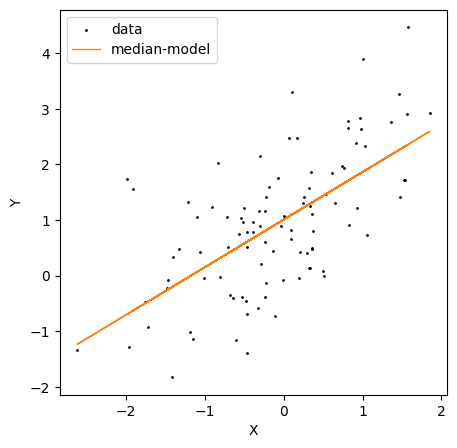

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X, Y, label='data', c='k', s=1)
ax.plot(X, alpha_[1]+beta_[1]*X, lw=1, c='C1', label='median-model')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

Mejor mostrar el HDI de los modelos.

/usr/local/lib/python3.12/dist-packages/arviz/plots/lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


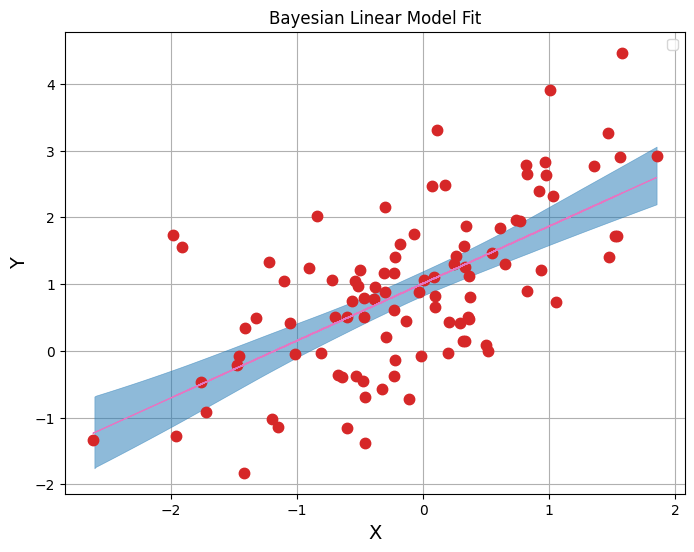

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
az.plot_lm(
    idata=trace,
    y="y_obs", x=X, axes=ax,
    y_model="mu",
    kind_model="hdi",    # model uncertainty interval
    y_hat_fill_kwargs={'hdi_prob': 0.68, 'alpha': 0.3, 'color': 'C0'})

ax.set_title("Bayesian Linear Model Fit")
ax.set_xlabel("X", fontsize=14)
ax.set_ylabel("Y", fontsize=14)
ax.plot([], [], color='C0', alpha=0.3, linewidth=10, label='68% HDI')
ax.legend('')
plt.show()

### Cornerplot

Otro método de inspección muy útil son los **corner plots**.

Donde se visualiza las marginales de cada parámetro en conjunto con las distribuciones conjuntas entre todos los pares de variables.

Además sirve para:
- Detectar patologías del modelo.
- Mostrar incertezas de los parámetros visualmente.

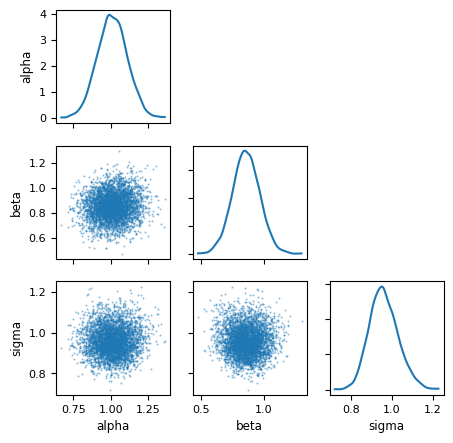

In [29]:
az.plot_pair(trace,
            var_names=['alpha', 'beta', 'sigma'],
            kind='scatter',
            marginals=True,
            figsize=(5,5),
            scatter_kwargs={'s':8, 'alpha':0.5},
            textsize=8);